In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [2]:
root_folder = os.path.join(raw_folder, 'third_attempt')

In [3]:
folders_list = sorted(os.listdir(root_folder))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=3, options=('Labels to replace', 'Labels to replace-20180619T192411Z-00…

In [4]:
folders_list = sorted(os.listdir(os.path.join(root_folder, type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', options=('a',), value='a')

In [5]:
annotation_folder = os.path.join(root_folder, type_dropdown.value, folder_dropdown.value)
print(annotation_folder)
print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

/home/mehrtash/dropbox/qanat_v2/raw/third_attempt/first attempt raw/a
True
no of tifs: 4


In [6]:
image_index = 1
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [7]:
labels = sorted(glob.glob(os.path.join(root_folder, type_dropdown.value, folder_dropdown.value) + '/' + '*label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 2


In [8]:
label_index = 1
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_border = sitk.BinaryDilate(label, 2)
label_nda = sitk.GetArrayFromImage(label)
label_nda = np.ma.masked_where(label_nda== 0, label_nda)
label_nda_border = sitk.GetArrayFromImage(label_border)
label_nda_border = np.ma.masked_where(label_nda_border== 0, label_nda_border)
#
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [9]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')
print(roi_path)
print(os.path.isfile(roi_path))

/home/mehrtash/dropbox/qanat_v2/raw/third_attempt/first attempt raw/a/DS1039-2088DA038_b_label_2.nrrd
/home/mehrtash/dropbox/qanat_v2/raw/third_attempt/first attempt raw/a/DS1039-2088DA038_b_label_2_roi.acsv
True


In [10]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [11]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[16202  7151] [18206  9155]


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])

In [14]:
nda.shape
#nda[start[1]:end[1], start[0]:end[0]].shape

(10992, 31425)

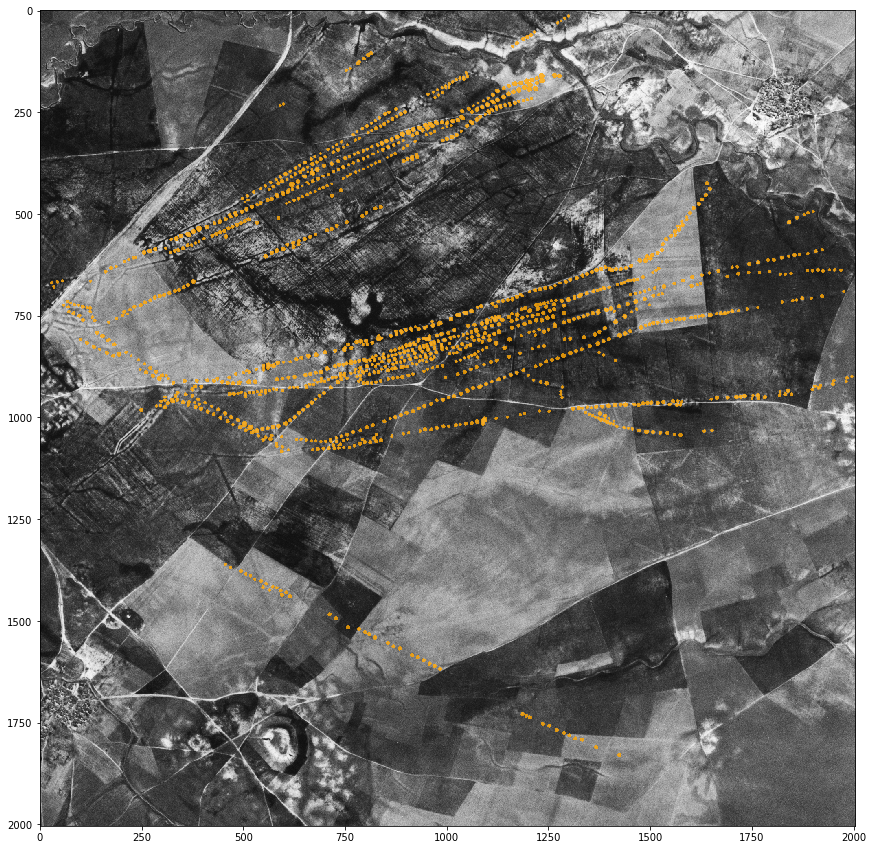

In [15]:
#
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8, cmap=cmap)
plt.savefig(os.path.join('../output/', folder_dropdown.value+'_'+ str(label_index) + '_patch.jpg'))

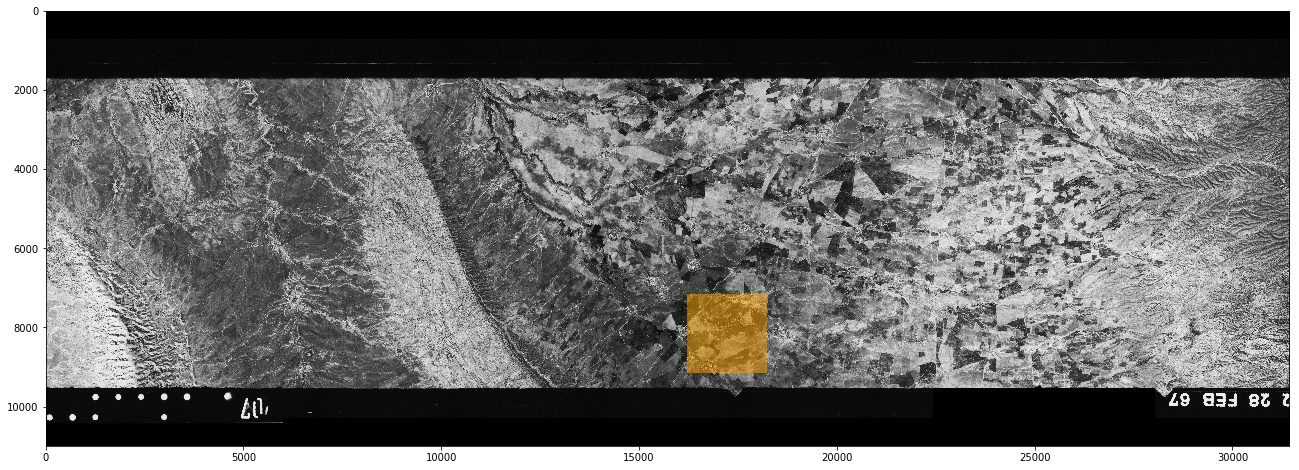

In [16]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.5,  cmap=cmap)
plt.savefig(os.path.join('../output/', folder_dropdown.value+'_'+ str(label_index) + '_section.jpg'))

In [17]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

1015


In [18]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

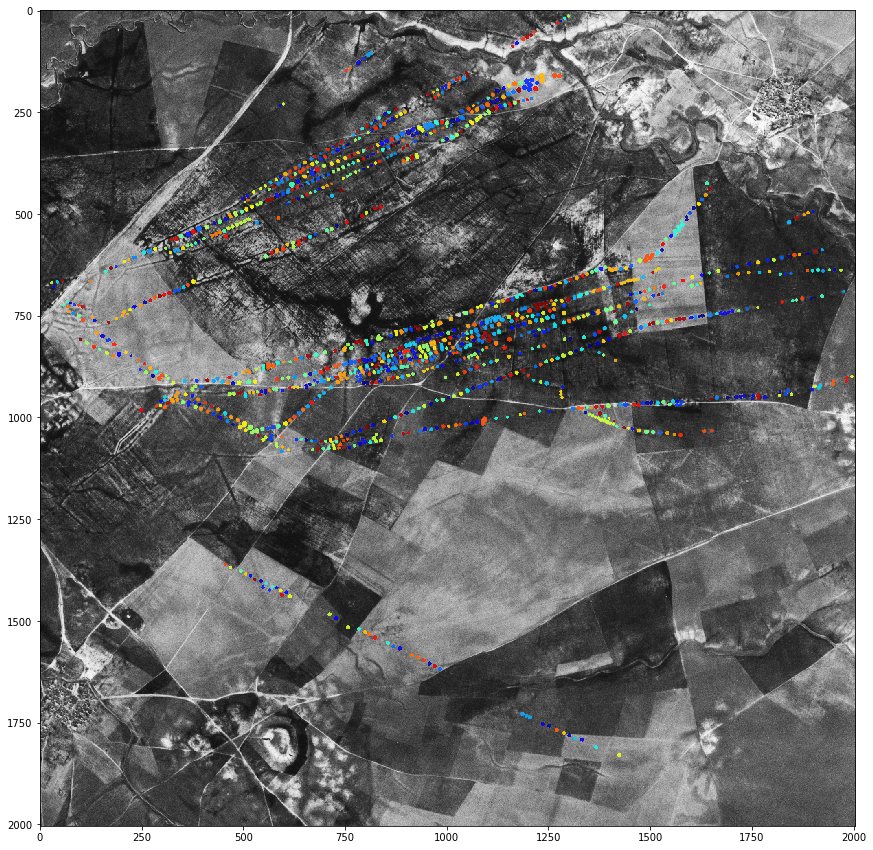

In [19]:
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [20]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [21]:
df = pd.DataFrame(d)

In [22]:
len(df)

1015

In [23]:
largest = df.sort_values('count', ascending=False).head(40)
smallest = df.sort_values('count', ascending=True).head(40)
largest

count  label      x     y
20      617     21  17399  7334
480     604    481  17318  7911
882     467    883  17584  8157
425     463    426  17433  7876
719     447    720  16943  8054
260     426    261  17770  7686
15      387     16  17429  7318
908     374    909  16725  8180
85      367     86  17156  7435
307     364    308  17697  7759
799     362    800  16532  8101
360     339    361  17649  7816
258     318    259  16699  7671
594     307    595  17141  7990
581     289    582  17112  7971
677     287    678  16768  8024
457     287    458  17887  7893
812     280    813  17922  8099
588     252    589  17150  7979
574     250    575  16986  7967
556     245    557  17151  7955
888     240    889  17292  8160
898     238    899  16699  8170
273     236    274  16634  7700
1005    232   1006  17395  8883
608     227    609  17120  7994
935     219    936  17024  8201
555     218    556  17036  7955
654     216    655  17004  8011
330     216    331  17608  7788
44      213     45  17319  7374
16      212     17  17471  7312
733     211    734  16984  8055
527     209    528  17275  7942
664     208    665  16969  8016
490     204    491  17774  7909
578     200    579  17165  7968
651     195    652  17073  8013
835     184    836  17771  8117
728     182    729  16497  8052

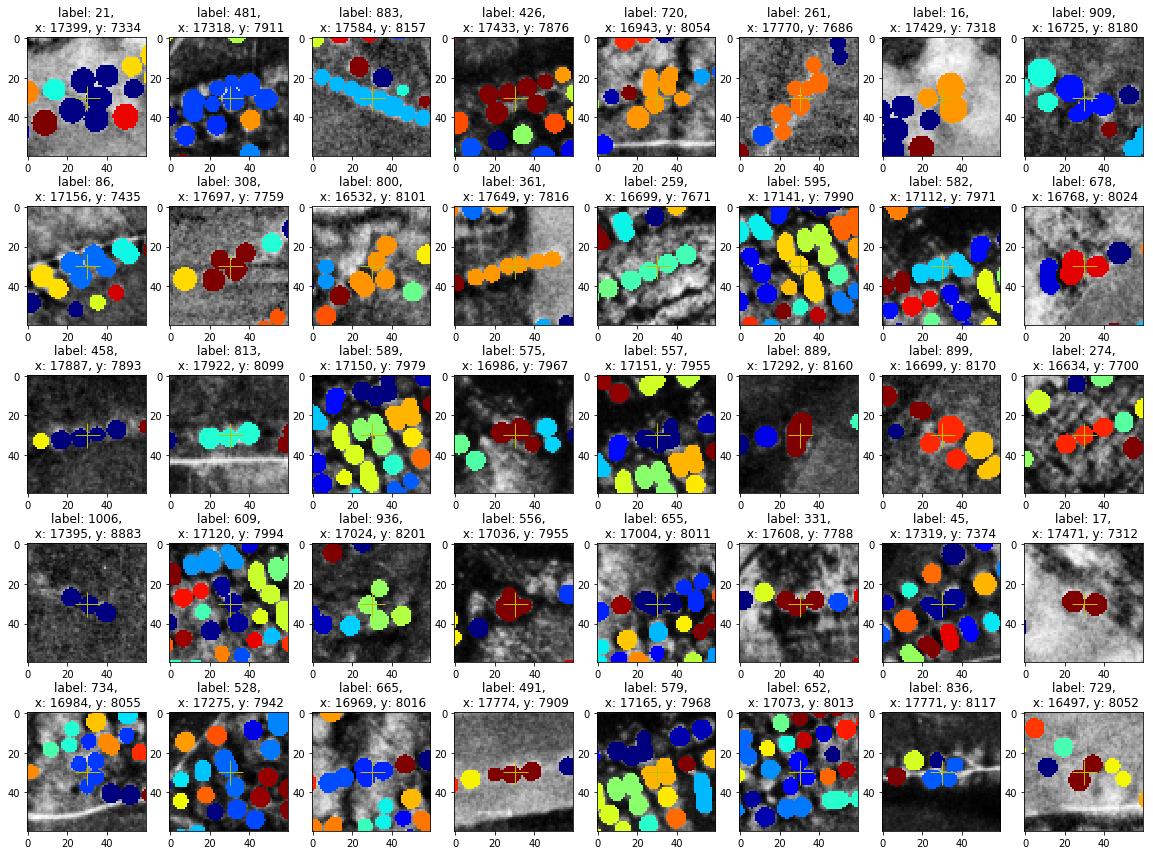

In [24]:
fig, axs = plt.subplots(5,8, figsize=(20, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=1, cmap=plt.cm.jet)
    axs[i].set_title('label: {},\n x: {}, y: {}'.format(label_val, x, y))
    axs[i].plot(pad,pad, 'y+', markersize=25,lw=2)
    i +=1

In [25]:
len(largest)

40

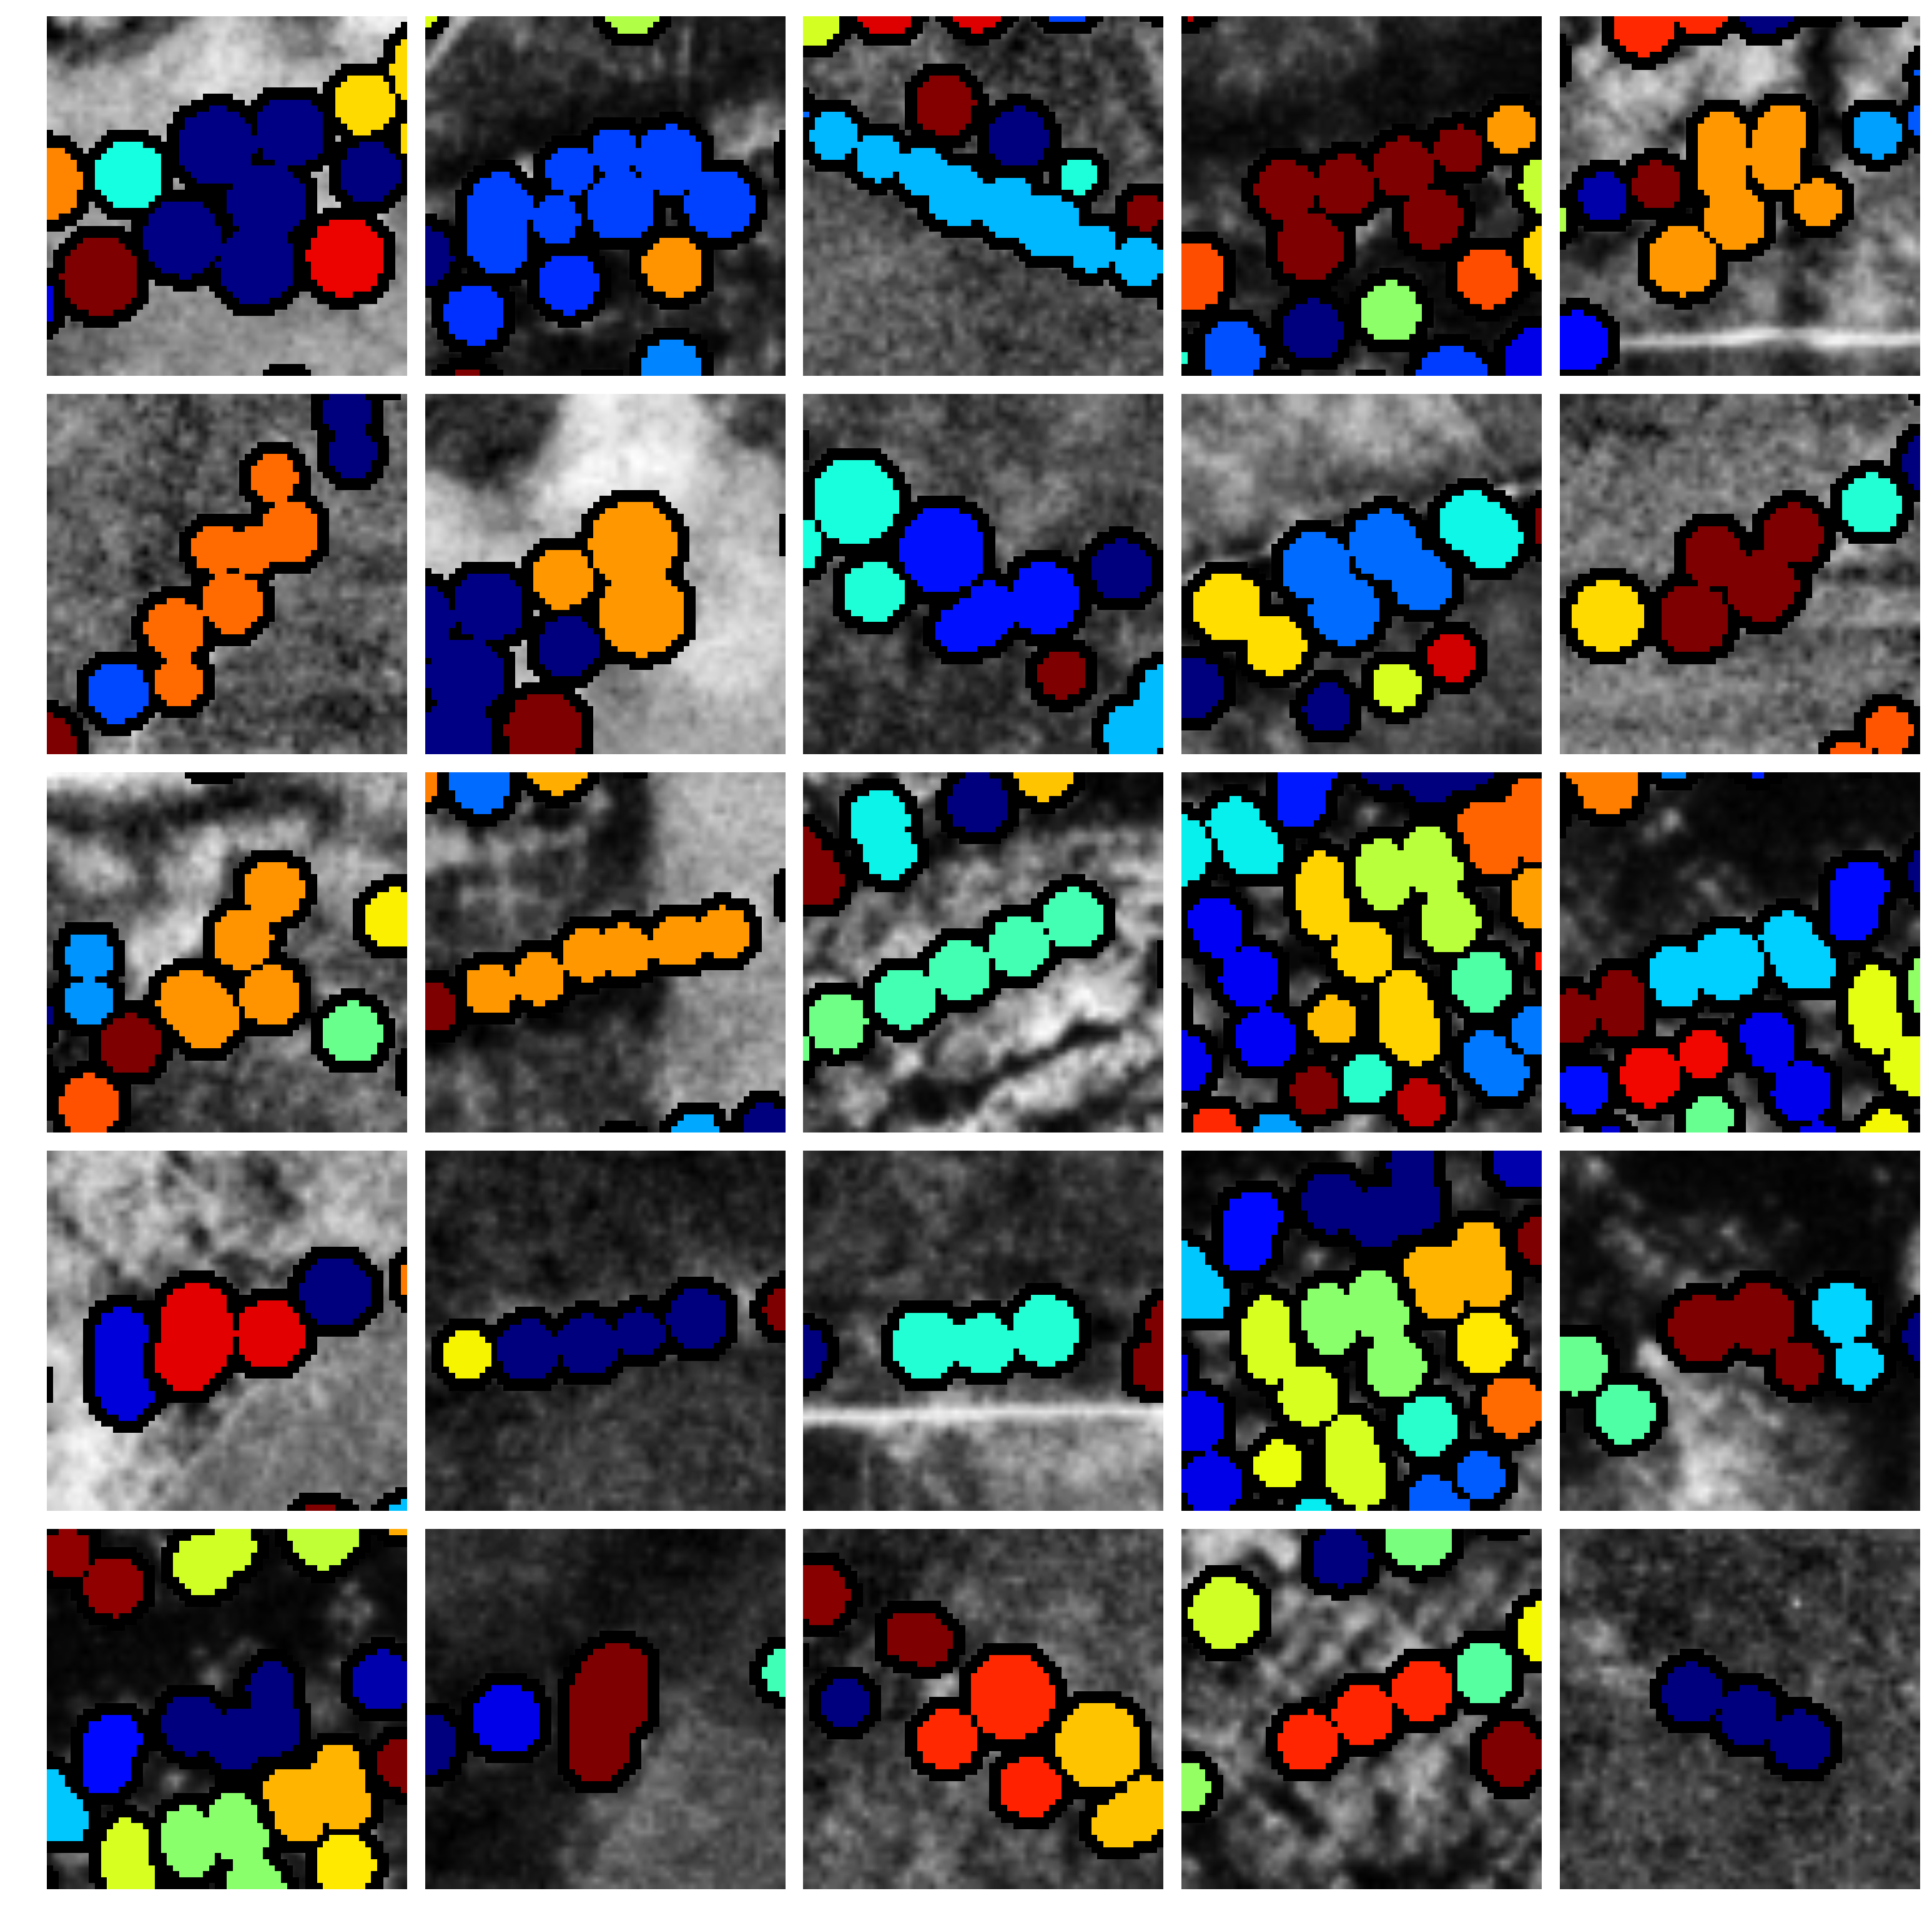

In [36]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k', dpi=200)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0.05, wspace=0.05)
pad = 30 
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    if i<25:
        x = row['x']
        y = row['y']
        label_val = row['label']
        axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray, interpolation='bilinear')
        axs[i].imshow(label_nda_border[0, -pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray, interpolation=None)
        axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=1, cmap=plt.cm.jet)
        axs[i].axis('off')
        i +=1


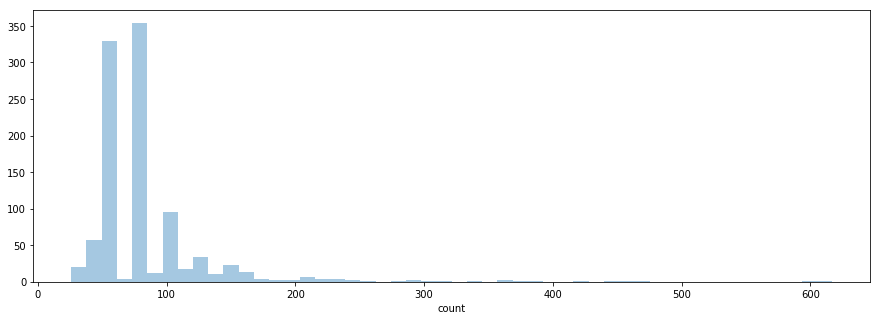

In [27]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'],  kde=False)

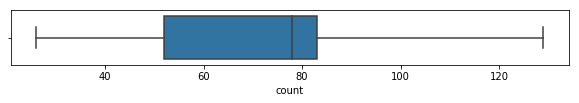

In [28]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)

In [31]:
label_nda_border.shape

(1, 10992, 31425)